In [26]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option("display.float_format", "{:.5f}".format)

In [40]:
files = ["2020-01", "2020-07"]
df = pd.concat(
    [
        pd.read_csv(
            f"../data/nyc_taxi_{fn}.csv",
            usecols=[
                "tpep_pickup_datetime",
                "passenger_count",
                "trip_distance",
                "total_amount",
            ],
            parse_dates=["tpep_pickup_datetime"],
        )
        for fn in files
    ]
)
df.describe()

,tpep_pickup_datetime,passenger_count,trip_distance,total_amount
count,7205420,7077132.00000,7205420.00000,7205420.00000
mean,2020-02-06 09:31:10.397394944,1.50106,3.08233,18.65963
min,2003-01-01 00:07:17,0.00000,-30.62000,-1242.30000
25%,2020-01-10 14:57:51,1.00000,0.97000,11.16000
50%,2020-01-18 19:43:33.500000,1.00000,1.61000,14.30000
75%,2020-01-27 16:26:22,2.00000,3.00000,19.89000
max,2021-01-02 01:12:10,9.00000,256069.13000,4268.30000
std,NaN,1.14122,176.28053,14.79138


In [41]:
# clean up the date data, adding columns for `month` and `year` and dropping all data not in January or July 2020
df["month"] = df["tpep_pickup_datetime"].dt.month
df["year"] = df["tpep_pickup_datetime"].dt.year
df["day"] = df["tpep_pickup_datetime"].dt.day
weekday_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
df["weekday"] = pd.Categorical(
    df["tpep_pickup_datetime"].dt.day_name(), categories=weekday_order, ordered=True
)
df = df.loc[(df["month"].isin((1, 7))) & (df["year"] == 2020)]
# make the `passenger_count` column be used as categorical data
df["passenger_count"] = df["passenger_count"].astype("category")
# reset the index to get rid of gaps from the dropped data
df = df.reset_index(drop=True)
# re-assign the data frame to a random sample of 1% of the original data
np.random.seed(0)
df = df.sample(frac=0.1)
df.describe()

,tpep_pickup_datetime,trip_distance,total_amount,month,year,day
count,720520,720520.00000,720520.00000,720520.00000,720520.00000,720520.00000
mean,2020-02-06 10:26:57.351444224,2.92145,18.64454,1.66708,2020.00000,16.60290
min,2020-01-01 00:00:05,-30.62000,-333.30000,1.00000,2020.00000,1.00000
25%,2020-01-10 14:53:52.249999872,0.97000,11.16000,1.00000,2020.00000,9.00000
50%,2020-01-18 19:48:30,1.60000,14.30000,1.00000,2020.00000,17.00000
75%,2020-01-27 16:43:13.500000,3.00000,19.89000,1.00000,2020.00000,24.00000
max,2020-07-31 23:59:43,259.22000,794.67000,7.00000,2020.00000,31.00000
std,NaN,3.87205,14.65034,1.88613,0.00000,8.85426


In [42]:
df.head()

,tpep_pickup_datetime,passenger_count,trip_distance,total_amount,month,year,day,weekday
7201592,2020-07-18 13:44:00,NaN,11.73000,49.20000,7,2020,18,Saturday
3111140,2020-01-16 19:05:14,3.00000,0.78000,12.25000,1,2020,16,Thursday
3854818,2020-01-20 15:57:03,1.00000,0.91000,12.09000,1,2020,20,Monday
427261,2020-01-03 16:44:46,1.00000,22.31000,65.92000,1,2020,3,Friday
234275,2020-01-02 13:19:53,1.00000,2.03000,17.16000,1,2020,2,Thursday


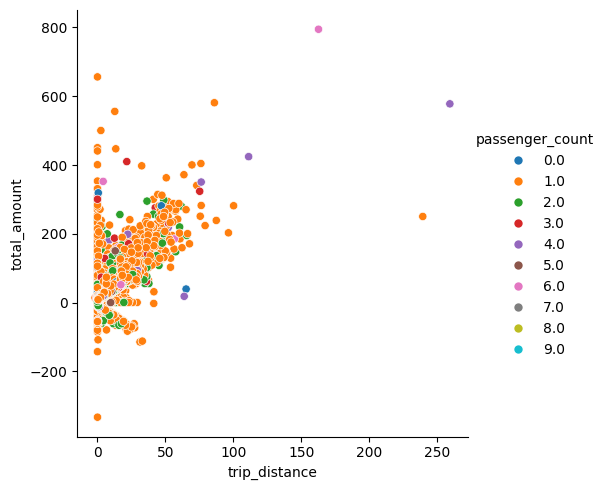

In [29]:
# scatter plot of `trip_distance` (x) and `total_amount` (y) with colour set by `passenger_count`
sns.relplot(
    kind="scatter", x="trip_distance", y="total_amount", hue="passenger_count", data=df
)
# `hue` tries to autodetect whether the data is continuous or categorical
# in this case passenger count is numeric, so it is detected as continuous, leading to some
# strange colourings.
# using `.astype("category")` gets it detected correctly (thanks Copilot, no thanks to seaborn docs or the book)

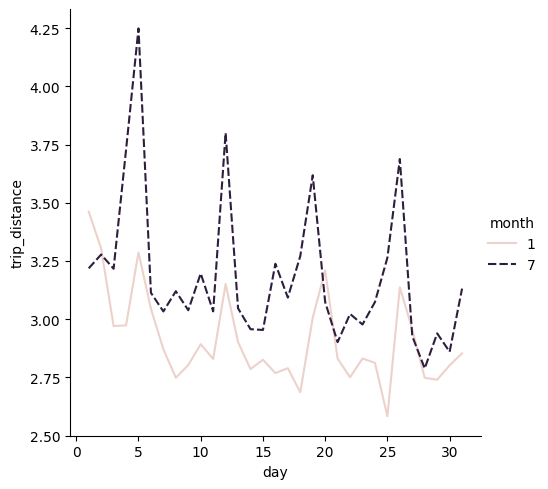

In [ ]:
# line plot for the distance travelled on day of January and July
sns.relplot(
    kind="line",
    x="day",
    y="trip_distance",
    data=df,
    style="month",
    hue="month",
    errorbar=None,  # confidence interval
)
# obvious spike on July 4th, but also regular what look like weekly spikes

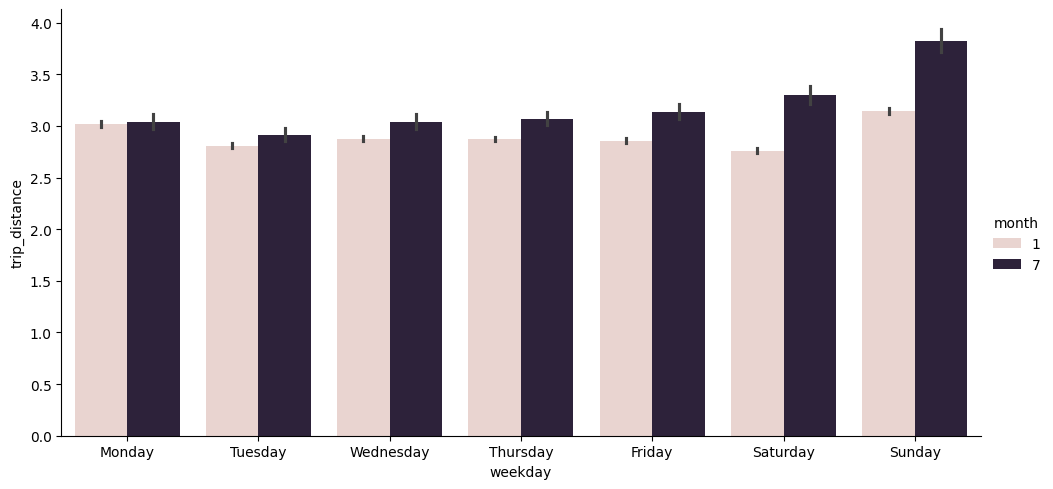

In [45]:
# let's look at this from the day of the week perspective
sns.catplot(kind="bar", x="weekday", y="trip_distance", hue="month", data=df, aspect=2)

In [47]:
# this gives us the basis for the next graph
df.groupby(["month", "day"])[["year"]].count()

year
month day       
1     1    16980
      2    16142
      3    18068
      4    18341
      5    16541
...          ...
7     27    2820
      28    3234
      29    3416
      30    3337
      31    3540

[62 rows x 1 columns]

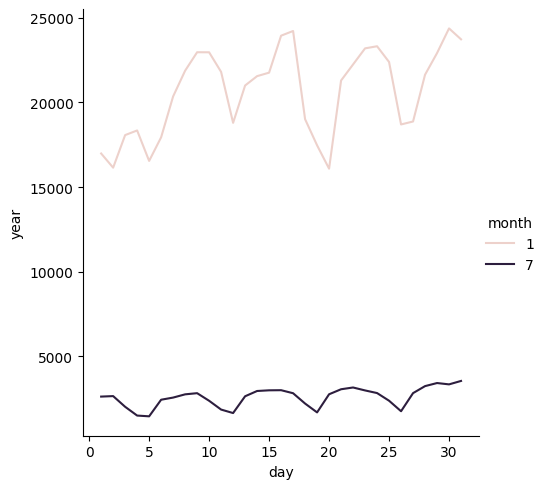

In [49]:
# show the number of trips taken on each day of both months
# the x axis should refer to the day of the month and the y axis should show the number of trips taken
sns.relplot(
    x="day",
    y="year",
    hue="month",
    kind="line",
    # apparently reset_index() pulls month and day back into the dataframe
    # from the index, but nothing appears to change if I take this out
    data=df.groupby(["month", "day"])[["year"]].count().reset_index(),
    errorbar=None,
)

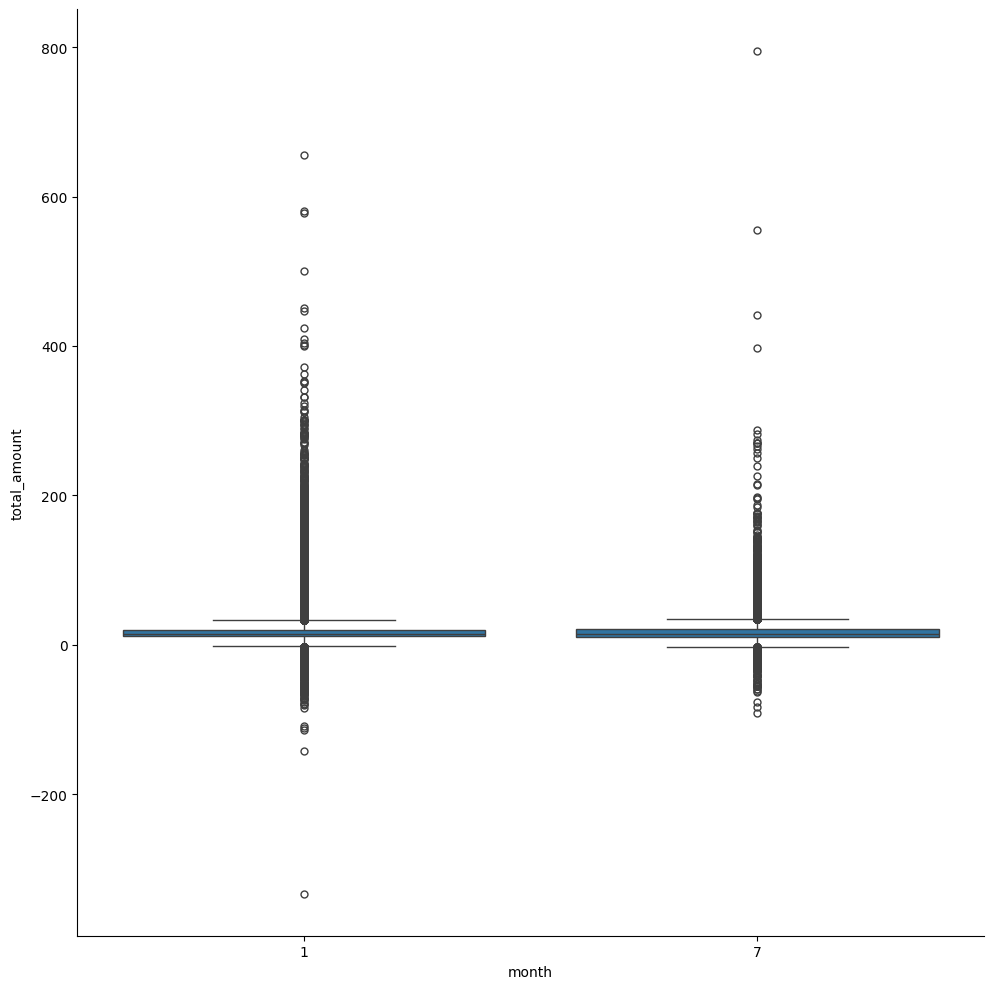

In [54]:
# create a box plot of `total_amount` with one plot for each month
sns.catplot(kind="box", x="month", y="total_amount", data=df, height=10)